# Tutorial

This tutorial implements three statistical inference methods in **"Efficient Inference for Nonparametric Hawkes Processes Using Auxiliary Latent Variables"**.

In the paper, we present an efficient Gibbs sampler, an EM algorithm and a mean-field variational inference algorithm with analytical expressions by using latent variable augmentation techniques. Please refer to the paper for more details. 

## Synthetic Data

From the `conjugate_np_hawkes` module, we import the `CNPHawkes` class. 

In [192]:
import numpy as np
import pandas as pd
import seaborn as sns # for plot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False}) # set seaborn style
import matplotlib.pyplot as plt # for plot
from conjugate_np_hawkes import CNPHawkes
from scipy.special import expit

Let us load the training and test data. Here we take Case 3 in the paper for an example. 

In [193]:
data = pd.read_csv("./train_data.csv")
points_hawkes=data['0'].to_list()
data = pd.read_csv("./test_data.csv")
points_hawkes_test=data['0'].to_list()

The training and test data both have observation window $[0,T=100]$ and the support of influence function $T_\phi=6$. We assume that there are $10$ inducing points on $[0,T]$ uniformly for $\mu(t)$, and $10$ inducing points on $[0,T_\phi]$ uniformly for $\phi(\tau)$. We initialise an instance of CNPHawkes with these hyperparameters. 

In [194]:
T=100
T_test=100
T_phi=6
xi_mu=np.linspace(0,T,10)   # 10 inducing points on [0,T]
xi_phi=np.linspace(0,T_phi,10)   # 10 inducing points on [0, T_phi]

In [195]:
toy_model = CNPHawkes(xi_mu,xi_phi,T_phi)

We set the training and test data with their corresponding observation window.

In [196]:
toy_model.set_train_test_data(points_hawkes,T,points_hawkes_test,T_test)

## Gibbs Sampler

In this section, we implement the Gibbs sampler to sample from the posterior of parameters. Besides, we compute the training and test log-likelihood along iterations to show the convergence. The resulting posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ are plotted to compare to the ground truth. 

Let us set the hyperparameters for the kernels of Gaussian processes.  

In [164]:
theta0_mu=2.7
theta1_mu=0.005
noise_var_mu=0.0
theta0_phi=5.0
theta1_phi=5.0
noise_var_phi=0.0
toy_model.set_kernel_hyperparameters(theta0_mu,theta1_mu,noise_var_mu,theta0_phi,theta1_phi,noise_var_phi)

Let us run the Gibbs sampler. `num_pre_mu` and `num_pre_phi` are the number of prediction points on $\mu(t)$ and $\phi(\tau)$ respectively. 

In [166]:
mu_list,phi_list,lamda_mu_list,lamda_phi_list,logl_train_list,logl_test_list=\
toy_model.Gibbs(num_pre_mu=1000,num_pre_phi=1000,num_iter=500)

Let us show the convergence using log-likelihood along iterations. 

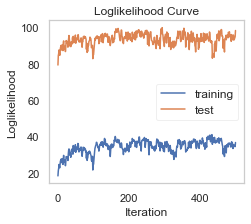

In [204]:
plt.figure(1,figsize=(3.5,3))
axs=plt.subplot(111)
axs.plot(range(len(logl_train_list_em)),logl_train_list,label='training')
axs.plot(range(len(logl_test_list_em)),logl_test_list,label='test')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Loglikelihood Curve',fontsize=12)
plt.legend(fontsize=12,framealpha =0.3)
plt.show()

The estimated posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ with the ground truth. 

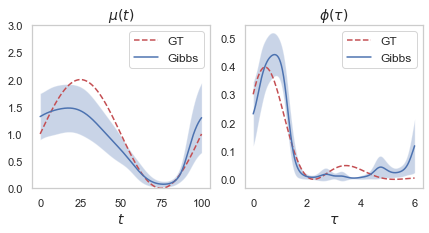

In [168]:
plt.figure(1,figsize=(7,3))
axs=plt.subplot(121)
axs.plot(np.linspace(0,T,100),np.sin(2*np.pi/100*np.linspace(0,T,100))+1,'r--',label='GT')
axs.plot(np.linspace(0,T,len(mu_list[0])),np.average(mu_list[-100:],axis=0),label='Gibbs')
axs.fill_between(np.linspace(0,T,len(mu_list[0])),np.average(mu_list[-100:],axis=0)-np.std(mu_list[-100:],axis=0),\
                 np.average(mu_list[-100:],axis=0)+np.std(mu_list[-100:],axis=0),alpha=0.3)
plt.ylim(0,3)
plt.xlabel(r'$t$',fontsize=14)
plt.title(r'$\mu(t)$',fontsize=14)
plt.legend(fontsize=12)

axs=plt.subplot(122)
axs.plot(np.linspace(0,T_phi,100),0.3*(np.sin(2*np.pi/3*np.linspace(0,6,100))+1)*np.exp(-0.7*np.linspace(0,6,100)),'r--',label='GT')
axs.plot(np.linspace(0,T_phi,len(phi_list[0])),np.average(phi_list[-100:],axis=0),label='Gibbs')
axs.fill_between(np.linspace(0,T_phi,len(phi_list[0])),np.average(phi_list[-100:],axis=0)-np.std(phi_list[-100:],axis=0),\
                 np.average(phi_list[-100:],axis=0)+np.std(phi_list[-100:],axis=0),alpha=0.3)
plt.xlabel(r'$\tau$',fontsize=14)
plt.title(r'$\phi(\tau)$',fontsize=14)
plt.legend(fontsize=12)
plt.show()

## EM Algorithm

In this section, we implement the EM algorithm to evaluate the MAP estimate of parameters. Besides, we compute the training and test log-likelihood along iterations to show the convergence. The resulting baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ are plotted to compare to the ground truth. 

Let us set the hyperparameters for the kernels of Gaussian processes. 

In [197]:
theta0_mu=2
theta1_mu=0.002
noise_var_mu=0
theta0_phi=5
theta1_phi=5
noise_var_phi=0
toy_model.set_kernel_hyperparameters(theta0_mu,theta1_mu,noise_var_mu,theta0_phi,theta1_phi,noise_var_phi)

Let us run the EM algorithm. `num_gq_mu` and `num_gq_phi` are the number of Gaussian quadrature nodes on $[0,T]$ and $[0,T_\phi]$ respectively; `num_pre_mu` and `num_pre_phi` are the number of prediction points on $\mu(t)$ and $\phi(\tau)$ respectively. 

In [198]:
mu_list_em,phi_list_em,lamda_mu_list_em,lamda_phi_list_em,logl_train_list_em,logl_test_list_em=\
toy_model.EM(num_gq_mu=100,num_gq_phi=100,num_pre_mu=1000,num_pre_phi=1000,num_iter=500)

Let us show the convergence using log-likelihood along iterations. 

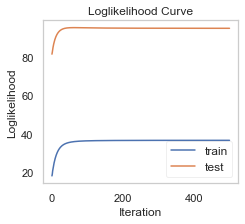

In [205]:
plt.figure(1,figsize=(3.5,3))
axs=plt.subplot(111)
axs.plot(range(len(logl_train_list_em)),logl_train_list_em,label='train')
axs.plot(range(len(logl_test_list_em)),logl_test_list_em,label='test')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Loglikelihood Curve',fontsize=12)
plt.legend(fontsize=12,framealpha =0.3)
plt.show()

The estimated baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ with the ground truth. 

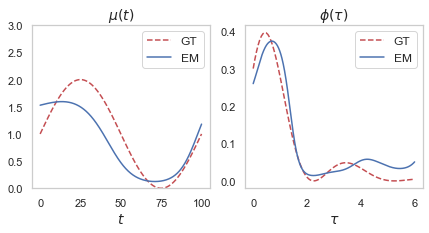

In [200]:
plt.figure(1,figsize=(7,3))
axs=plt.subplot(121)
axs.plot(np.linspace(0,T,100),np.sin(2*np.pi/100*np.linspace(0,T,100))+1,'r--',label='GT')
axs.plot(np.linspace(0,T,len(mu_list_em[-1])),mu_list_em[-1],label='EM')
plt.ylim(0,3)
plt.xlabel(r'$t$',fontsize=14)
plt.title(r'$\mu(t)$',fontsize=14)
plt.legend(fontsize=12)

axs=plt.subplot(122)
axs.plot(np.linspace(0,6,100),0.3*(np.sin(2*np.pi/3*np.linspace(0,6,100))+1)*np.exp(-0.7*np.linspace(0,6,100)),'r--',label='GT')
axs.plot(np.linspace(0,T_phi,len(phi_list_em[-1])),phi_list_em[-1],label='EM')
plt.xlabel(r'$\tau$',fontsize=14)
plt.title(r'$\phi(\tau)$',fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Mean-Field Variational Inference

In this section, we implement the mean-field algorithm to evaluate the approximated posterior of parameters. Besides, we compute the training and test log-likelihood (using mean) along iterations to show the convergence. The resulting posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ are plotted to compare to the ground truth. 

Let us set the hyperparameters for the kernels of Gaussian processes. 

In [132]:
theta0_mu=1
theta1_mu=0.003
noise_var_mu=0
theta0_phi=4
theta1_phi=4
noise_var_phi=0
toy_model.set_kernel_hyperparameters(theta0_mu,theta1_mu,noise_var_mu,theta0_phi,theta1_phi,noise_var_phi)

Let us run the mean-field algorithm. `num_gq_mu` and `num_gq_phi` are the number of Gaussian quadrature nodes on $[0,T]$ and $[0,T_\phi]$ respectively; `num_pre_mu` and `num_pre_phi` are the number of prediction points on $\mu(t)$ and $\phi(\tau)$ respectively. 

In [134]:
%%time
mean_g_mu_mf, cov_g_mu_mf, mean_g_phi_mf, cov_g_phi_mf, lamda_mu_mean_mf, lamda_mu_var_mf, lamda_phi_mean_mf, lamda_phi_var_mf,\
logl_train_list_mf, logl_test_list_mf=toy_model.MF(num_gq_mu=100,num_gq_phi=100,num_pre_mu=1000,num_pre_phi=3000,num_iter=500)

Wall time: 9min 15s


Let us show the convergence using log-likelihood along iterations. 

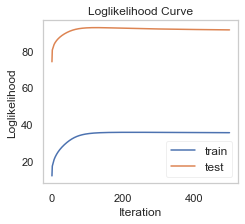

In [206]:
plt.figure(1,figsize=(3.5,3))
axs=plt.subplot(111)
axs.plot(range(len(logl_train_list_mf)),logl_train_list_mf,label='train')
axs.plot(range(len(logl_test_list_mf)),logl_test_list_mf,label='test')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Loglikelihood Curve',fontsize=12)
plt.legend(fontsize=12,framealpha =0.3)
plt.show()

The estimated posterior of baseline intensity $\mu(t)$ and influence function $\phi(\tau)$ with the ground truth. 

In [136]:
mu_mean_mf=lamda_mu_mean_mf*expit(mean_g_mu_mf)
phi_mean_mf=lamda_phi_mean_mf*expit(mean_g_phi_mf)
mu_ub_mf=(lamda_mu_mean_mf+np.sqrt(lamda_mu_var_mf))*expit(mean_g_mu_mf+np.sqrt(np.diag(cov_g_mu_mf)))
phi_ub_mf=(lamda_phi_mean_mf+np.sqrt(lamda_phi_var_mf))*expit(mean_g_phi_mf+np.sqrt(np.diag(cov_g_phi_mf)))
mu_lb_mf=(lamda_mu_mean_mf-np.sqrt(lamda_mu_var_mf))*expit(mean_g_mu_mf-np.sqrt(np.diag(cov_g_mu_mf)))
phi_lb_mf=(lamda_phi_mean_mf-np.sqrt(lamda_phi_var_mf))*expit(mean_g_phi_mf-np.sqrt(np.diag(cov_g_phi_mf)))

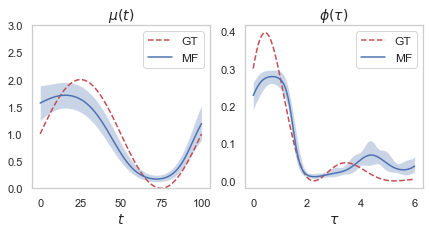

In [137]:
plt.figure(1,figsize=(7,3))
axs=plt.subplot(121)
axs.plot(np.linspace(0,T,100),np.sin(2*np.pi/100*np.linspace(0,T,100))+1,'r--',label='GT')
axs.plot(np.linspace(0,T,len(mu_mean_mf)),mu_mean_mf,label='MF')
axs.fill_between(np.linspace(0,T,len(mu_mean_mf)),mu_lb_mf,mu_ub_mf,alpha=0.3)
plt.ylim(0,3)
plt.xlabel(r'$t$',fontsize=14)
plt.title(r'$\mu(t)$',fontsize=14)
plt.legend(fontsize=12)

axs=plt.subplot(122)
axs.plot(np.linspace(0,T_phi,100),0.3*(np.sin(2*np.pi/3*np.linspace(0,6,100))+1)*np.exp(-0.7*np.linspace(0,6,100)),'r--',label='GT')
axs.plot(np.linspace(0,T_phi,len(phi_mean_mf)),phi_mean_mf,label='MF')
axs.fill_between(np.linspace(0,T_phi,len(phi_mean_mf)),phi_lb_mf,phi_ub_mf,alpha=0.3)
plt.xlabel(r'$\tau$',fontsize=14)
plt.title(r'$\phi(\tau)$',fontsize=14)
plt.legend(fontsize=12)
plt.show()